| Number of Simulation | Simulation Goal | Number of miners | Mining power | Network Power |
| --- | --- | --- | --- | --- |
| 1 | Determine the effect of an increasing mining power of just one selfish miner | 1 selfish and 99 honest | Increasing the mining power of the one selfish miner and decreasing the mining power of the honest miner(s) throughout the simulations | Random for all miners |
| 2 | Determine the effect of an increasing number of selfish miners where all honest and selfish miners have equal mining power | increasing the number of selfish miner(s) and therefore their total selfish mining power, and decreasing the number of honest miner(s) and therefore their total honest mining power throughout the simulation | Equal between all miners | Random for all miners |
| 3 | Determine the effect of an increasing network power of just one selfish miner  | 1 selfish and 99 honest | Equal between all miners | Increasing the network power of the selfish miner(s) and decreasing the network power of the honest miner(s) throughout the simulations |
| 4 | Determine the effect of an increasing number of selfish miners where all honest and selfish miners have equal network and mining power | increasing the number of selfish miner(s) and therefore their total selfish network power, and decreasing the number of honest miner(s) and therefore their total honest network power throughout the simulation | Equal between all miners | Equal between all miners |

### 1) Mining Power Analysis and Simulation

In [4]:
import random
import hashlib as hasher

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))

class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        r = random.choices(maxes, k=1)
        return r[0]
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()
  
    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                bc.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        #add this function
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        #add this function - selfish PoW
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

In [2]:
"""
A method that runs the simulation of mining

Inputs: 
- The blockchain instance (bc),
- An array of honest miners (honest_miners),
- An array of selfish miners (selfish_miners)

Outputs:
- The percentage of blocks mined by honest miners (honest_profit)
- The percentage of blocks mined by selfish miners (selfish_profit)
"""
def simulate_selfish_mining(bc, honest_miners, selfish_miners):
    run_to = 101
    while bc.size < run_to:
        for s in selfish_miners:
            s.PoWSolver()

        for m in honest_miners:
            m.PoWSolver()

        for s in selfish_miners:
            s.UpdateLast()

        for m in honest_miners:
            m.UpdateLast()
    
    selfish_profit = 0
    bc_height = bc.longestChain().height
    for selfish_miner in selfish_miners:
        percentage_of_miner_blocks = bc.checkMiner(selfish_miner) / bc_height
        selfish_profit += percentage_of_miner_blocks
    
    honest_profit = 0
    for honest_miner in honest_miners:
        percentage_of_miner_blocks = bc.checkMiner(honest_miner) / bc_height
        honest_profit += percentage_of_miner_blocks
        
    return selfish_profit, honest_profit

In [3]:
"""
--- Simulation Details ---
A) Total available mining power of 100
B) starting the total selfish mining power at 0, and
C) starting the total honest mining power at 100

D) Total number of miners is 100

E) Mining power will vary from one miner to another, beacuse we are
    1. Increasing the mining power of the 1 selfish miner from 0 to 99 with selfish_power += 1
    2. decreasing the mining power of the 99 honest miners from 100 to 1 with honest_power -= 1
"""

def make_miners(type_of_minors, num_of_miners, total_mining_power):
    miners = []
    remaining_mining_power = total_mining_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", bc)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", bc)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

output = True # Set this to False to disable update messages from simulations
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for selfish_power in sim_range_selfish:
    num_of_selfish_miners = 1
    num_of_honest_miners = 99
    total_mining_power = 100
    honest_power_share = round((100-selfish_power)/100, 2) 
    selfish_power_share = round(selfish_power/100, 2) 
    
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    bc = Blockchain("0" , 11)

    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power)
    
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power)
        
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {len(honest_miners)} honest minors having {round(honest_power_share*100)}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {round(selfish_power_share*100)}% of total mining power")
        print("...")
    
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()

Running simulation of mining power with:
-> 99 honest minors having 100% of total mining power
-> 1 selfish minors having 0% of total mining power
...
Honest profit: 0.9999999999999994
Selfish profit: 0.0
Total profit: 0.9999999999999994

Running simulation of mining power with:
-> 99 honest minors having 99% of total mining power
-> 1 selfish minors having 1% of total mining power
...
Honest profit: 0.9895833333333333
Selfish profit: 0.010416666666666666
Total profit: 0.9999999999999999

Running simulation of mining power with:
-> 99 honest minors having 98% of total mining power
-> 1 selfish minors having 2% of total mining power
...
Honest profit: 0.9897959183673477
Selfish profit: 0.01020408163265306
Total profit: 1.0000000000000007

Running simulation of mining power with:
-> 99 honest minors having 97% of total mining power
-> 1 selfish minors having 3% of total mining power
...
Honest profit: 0.9583333333333333
Selfish profit: 0.041666666666666664
Total profit: 0.999999999999999

Honest profit: 0.6923076923076922
Selfish profit: 0.3076923076923077
Total profit: 0.9999999999999999

Running simulation of mining power with:
-> 99 honest minors having 67% of total mining power
-> 1 selfish minors having 33% of total mining power
...
Honest profit: 0.7976190476190474
Selfish profit: 0.20238095238095238
Total profit: 0.9999999999999998

Running simulation of mining power with:
-> 99 honest minors having 66% of total mining power
-> 1 selfish minors having 34% of total mining power
...
Honest profit: 0.7088607594936707
Selfish profit: 0.27848101265822783
Total profit: 0.9873417721518984

Running simulation of mining power with:
-> 99 honest minors having 65% of total mining power
-> 1 selfish minors having 35% of total mining power
...
Honest profit: 0.7407407407407409
Selfish profit: 0.25925925925925924
Total profit: 1.0000000000000002

Running simulation of mining power with:
-> 99 honest minors having 64% of total mining power
-> 1 selfish minors having 36% of tota

Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 32% of total mining power
-> 1 selfish minors having 68% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 31% of total mining power
-> 1 selfish minors having 69% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 30% of total mining power
-> 1 selfish minors having 70% of total mining power
...
Honest profit: 0.9591836734693877
Selfish profit: 0.04081632653061224
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 29% of total mining power
-> 1 selfish minors having 71% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1.0

Running simulation of mining power with:
-> 99 honest minors having 28% of 

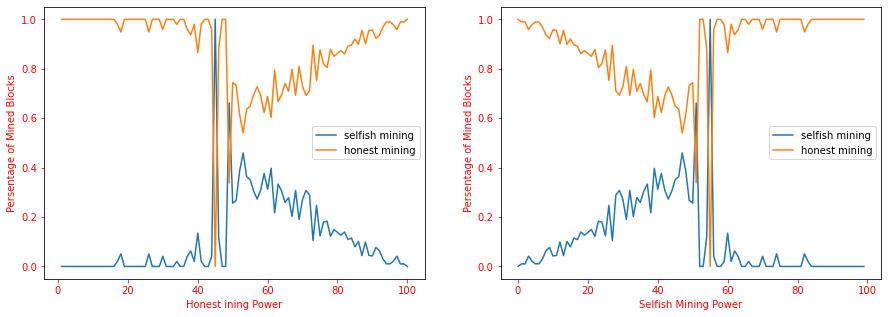

In [4]:
"""
Drawing the results of the previous simulation

--- Simulation Details ---
A) Total available mining power of 100
B) starting the total selfish mining power at 0, and
C) starting the total honest mining power at 100

D) Total number of minors is 100

E) Mining power will vary from one miner to another, beacuse we are
1. Increasing the mining power of the 1 selfish miner from 0 to 99 with selfish_power += 1
2. decreasing the mining power of the 99 honest miners from 100 to 1 with honest_power -= 1
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of honest network power of the total network power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish network power of the total network power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[1].legend()

### 2) Analysis and Simulation of Increasing The Number of Selfish Miners

In [5]:
"""
--- Simulation Details ---
A) Total available mining power of 100
B) starting the total selfish mining power at 0, and
C) starting the total honest mining power at 100

D) Total number of miners is 100

E) Each miner will have the same mining power as other miners, beacuse we are
1. Increasing the selfish mining power from 0 to 99 with selfish_power += 1, and 
    at the same time increasing the number of selfish miners from 0 to 99 with 
    num_selfish_miners += 1
2. decreasing the honest mining power from 0 to 99 with honest_power += 1, and 
    at the same time decreasing the number of honest miners from 0 to 99 with 
    num_honest_miners += 1
"""

def make_miners(type_of_minors, num_of_miners, total_mining_power):
    miners = []
    remaining_mining_power = total_mining_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", bc)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", bc)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

output = True # Set this to False to disable update messages from simulations
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)

    bc = Blockchain("0" , 11)
    
    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power)
    
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power)
        
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {len(honest_miners)} honest minors having {round(honest_power_share*100)}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {round(selfish_power_share*100)}% of total mining power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()
    

Running simulation of mining power with:
-> 100 honest minors having 100% of total mining power
-> 0 selfish minors having 0% of total mining power
...
Honest profit: 1.0000000000000007
Selfish profit: 0
Total profit: 1.0000000000000007

Running simulation of mining power with:
-> 99 honest minors having 99% of total mining power
-> 1 selfish minors having 1% of total mining power
...
Honest profit: 0.9793814432989688
Selfish profit: 0.020618556701030927
Total profit: 0.9999999999999998

Running simulation of mining power with:
-> 98 honest minors having 98% of total mining power
-> 2 selfish minors having 2% of total mining power
...
Honest profit: 0.9891304347826092
Selfish profit: 0.0
Total profit: 0.9891304347826092

Running simulation of mining power with:
-> 97 honest minors having 97% of total mining power
-> 3 selfish minors having 3% of total mining power
...
Honest profit: 0.9999999999999998
Selfish profit: 0.0
Total profit: 0.9999999999999998

Running simulation of mining po

Honest profit: 0.7826086956521737
Selfish profit: 0.21739130434782605
Total profit: 0.9999999999999998

Running simulation of mining power with:
-> 66 honest minors having 66% of total mining power
-> 34 selfish minors having 34% of total mining power
...
Honest profit: 0.8529411764705879
Selfish profit: 0.16176470588235295
Total profit: 1.014705882352941

Running simulation of mining power with:
-> 65 honest minors having 65% of total mining power
-> 35 selfish minors having 35% of total mining power
...
Honest profit: 0.7619047619047618
Selfish profit: 0.23809523809523808
Total profit: 0.9999999999999998

Running simulation of mining power with:
-> 64 honest minors having 64% of total mining power
-> 36 selfish minors having 36% of total mining power
...
Honest profit: 0.791044776119403
Selfish profit: 0.20895522388059695
Total profit: 1.0

Running simulation of mining power with:
-> 63 honest minors having 63% of total mining power
-> 37 selfish minors having 37% of total mining pow

Honest profit: 0.5250000000000001
Selfish profit: 0.45000000000000007
Total profit: 0.9750000000000002

Running simulation of mining power with:
-> 33 honest minors having 33% of total mining power
-> 67 selfish minors having 67% of total mining power
...
Honest profit: 0.5526315789473683
Selfish profit: 0.42105263157894735
Total profit: 0.9736842105263156

Running simulation of mining power with:
-> 32 honest minors having 32% of total mining power
-> 68 selfish minors having 68% of total mining power
...
Honest profit: 0.6486486486486487
Selfish profit: 0.32432432432432434
Total profit: 0.972972972972973

Running simulation of mining power with:
-> 31 honest minors having 31% of total mining power
-> 69 selfish minors having 69% of total mining power
...
Honest profit: 0.4571428571428572
Selfish profit: 0.5428571428571429
Total profit: 1.0

Running simulation of mining power with:
-> 30 honest minors having 30% of total mining power
-> 70 selfish minors having 70% of total mining pow

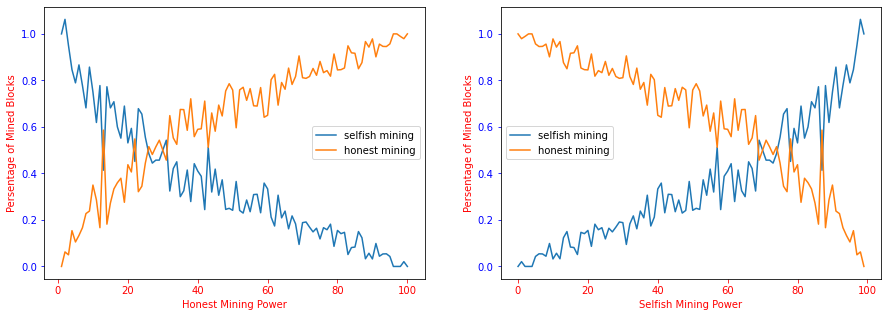

In [6]:
"""
Drawing the results of the previous simulation

--- Simulation Details ---
A) Total available mining power of 100
B) starting the total selfish mining power at 0, and
C) starting the total honest mining power at 100

D) Total number of miners is 100

E) Each miner will have the same mining power as other miners, beacuse we are
1. Increasing the selfish mining power from 0 to 99 with selfish_power += 1, and 
    at the same time increasing the number of selfish miners from 0 to 99 with 
    num_selfish_miners += 1
2. decreasing the honest mining power from 0 to 99 with honest_power += 1, and 
    at the same time decreasing the number of honest miners from 0 to 99 with 
    num_honest_miners += 1
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='blue')
axs[0].set_xlabel('Percentage of honest network power of the total network power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='blue')
axs[1].set_xlabel('Percentage of selfish network power of the total network power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks').set_color('red')
axs[1].legend()

# Network Power Analysis and Simulation

In [8]:
"""
# Redesigning the longestChain() mehtod in the Blockchain class to simulate network power
# Ask assistent about the different 2 approaches in longestChain() and choose the right one???
"""

class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            if creator != None:
                self.creator = Miner(0 , creator.networkingPower, creator.miner_type ,"0")
            else:
                self.creator = Miner(0 , None, None, "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))


class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self, miner_networking_power, miner_type):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        
        new_maxes = []
        if len(maxes) > 1:
            chances = list(range(1, 101, 1))
            choice = random.choice(chances)
            for block in maxes:
                """
                if choice <= miner_networking_power and miner_type == block.creator.miner_type:
                    # Miner type(honest/selfish) wins, the other type(honest/selfish) loses
                    new_maxes.append(block)
                elif choice > miner_networking_power and miner_type != block.creator.miner_type:
                    # Miner type(honest/selfish) loses, the other type(honest/selfish) wins
                    new_maxes.append(block)
                """
                creator_networking_power = block.creator.networkingPower
                if choice <= creator_networking_power:
                    # Miner type(honest/selfish) wins, the other type(honest/selfish) loses
                    new_maxes.append(block)
        else:
            new_maxes = maxes
            
        if len(new_maxes) == 0:
            new_maxes = maxes
        return new_maxes[0]
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last = self.longestChain(miner.networkingPower, miner.miner_type)
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        self.miningPower = miningPower
        self.networkingPower = networkingPower
        self.miner_type = miner_type
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain(self.networkingPower, self.miner_type)
  
    def UpdateLast(self):
        latest = self.blockchain.longestChain(self.networkingPower, self.miner_type)
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                bc.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        super().__init__(miningPower, networkingPower, miner_type, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        #add this function
        latest = self.blockchain.longestChain(self.networkingPower, self.miner_type)
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

In [9]:
def simulate_selfish_mining(bc, legal_miners, selfish_miners):
    run_to = 101
    while bc.size < run_to:
        for s in selfish_miners:
            s.PoWSolver()

        for m in legal_miners:
            m.PoWSolver()

        for s in selfish_miners:
            s.UpdateLast()

        for m in legal_miners:
            m.UpdateLast()
    
    selfish_profit = 0
    for miner in selfish_miners:
        bc_height = bc.longestChain(miner.networkingPower, miner.miner_type).height
        percentage_of_miner_blocks = bc.checkMiner(miner) / bc_height
        selfish_profit += percentage_of_miner_blocks
    
    honest_profit = 0
    for miner in legal_miners:
        bc_height = bc.longestChain(miner.networkingPower, miner.miner_type).height
        percentage_of_miner_blocks = bc.checkMiner(miner) / bc_height
        honest_profit += percentage_of_miner_blocks
        
    return selfish_profit, honest_profit

In [11]:
"""
--- Simulation Details ---
A) Total available mining power of 100
B) Total number of miners is 100
C) Mining power are equal for each miner, i.e. 1 for each miner
D) Having 99 honest miners, and 1 selfish miners at each step throughout the simulation

E) Total available network power of 100
F) Miners have different network powers, beacuse we are
1. Increasing the total selfish network power from 0 to 99 with selfish_network_power += 1, and
    this total amount of selfish network power is dedicated to the one selfish miner.
2. Decreasing the total honest network power from 100 to 1 with honest_network_power -= 1, and
    this total amount of honest network power is divided on the 99 honest miners.
"""
import random

def make_miners(type_of_minors, total_network_power, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    remaining_network_power = total_network_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
            network_power = remaining_network_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            
            if remaining_network_power != 0:
                possible_network_power = list(range(1, remaining_network_power+1, 1))
                network_power = random.choice(possible_network_power)
                remaining_network_power -= network_power
            else:
                network_power = 0
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, network_power, "Selfish", f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

output = True
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

for i in sim_range_selfish:
    num_of_selfish_miners = 1
    num_of_honest_miners = 99
    
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    selfish_networking_power = i
    honest_networking_power = 100-i
    
    bc = Blockchain("0" , 11)
    
    honest_miners = make_miners("honest", honest_networking_power, num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", selfish_networking_power, num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation of networking power with:")
        print(f"-> {len(honest_miners)} honest minors having {honest_networking_power}% of total networking power")
        print(f"-> {len(selfish_miners)} selfish minors having {selfish_networking_power}% of total networking power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {selfish_profit+honest_profit}")
        print()
    


Running simulation of networking power with:
-> 99 honest minors having 100% of total networking power
-> 1 selfish minors having 0% of total networking power
...
Honest profit: 0.9999999999999993
Selfish profit: 0.0
Total profit: 0.9999999999999993

Running simulation of networking power with:
-> 99 honest minors having 99% of total networking power
-> 1 selfish minors having 1% of total networking power
...
Honest profit: 1.0000000000000007
Selfish profit: 0.0
Total profit: 1.0000000000000007

Running simulation of networking power with:
-> 99 honest minors having 98% of total networking power
-> 1 selfish minors having 2% of total networking power
...
Honest profit: 0.9999999999999999
Selfish profit: 0.0
Total profit: 0.9999999999999999

Running simulation of networking power with:
-> 99 honest minors having 97% of total networking power
-> 1 selfish minors having 3% of total networking power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004


Honest profit: 0.9894736842105265
Selfish profit: 0.010526315789473684
Total profit: 1.0000000000000002

Running simulation of networking power with:
-> 99 honest minors having 66% of total networking power
-> 1 selfish minors having 34% of total networking power
...
Honest profit: 0.9895833333333329
Selfish profit: 0.010416666666666666
Total profit: 0.9999999999999996

Running simulation of networking power with:
-> 99 honest minors having 65% of total networking power
-> 1 selfish minors having 35% of total networking power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004

Running simulation of networking power with:
-> 99 honest minors having 64% of total networking power
-> 1 selfish minors having 36% of total networking power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004

Running simulation of networking power with:
-> 99 honest minors having 63% of total networking power
-> 1 selfish minors hav

Honest profit: 0.9898989898989894
Selfish profit: 0.010101010101010102
Total profit: 0.9999999999999994

Running simulation of networking power with:
-> 99 honest minors having 34% of total networking power
-> 1 selfish minors having 66% of total networking power
...
Honest profit: 1.0000000000000007
Selfish profit: 0.0
Total profit: 1.0000000000000007

Running simulation of networking power with:
-> 99 honest minors having 33% of total networking power
-> 1 selfish minors having 67% of total networking power
...
Honest profit: 0.9898989898989896
Selfish profit: 0.010101010101010102
Total profit: 0.9999999999999997

Running simulation of networking power with:
-> 99 honest minors having 32% of total networking power
-> 1 selfish minors having 68% of total networking power
...
Honest profit: 0.9892473118279564
Selfish profit: 0.010752688172043012
Total profit: 0.9999999999999994

Running simulation of networking power with:
-> 99 honest minors having 31% of total networking power
-> 1 s

Honest profit: 0.9900000000000005
Selfish profit: 0.01
Total profit: 1.0000000000000004

Running simulation of networking power with:
-> 99 honest minors having 2% of total networking power
-> 1 selfish minors having 98% of total networking power
...
Honest profit: 0.9897959183673476
Selfish profit: 0.01020408163265306
Total profit: 1.0000000000000007

Running simulation of networking power with:
-> 99 honest minors having 1% of total networking power
-> 1 selfish minors having 99% of total networking power
...
Honest profit: 1.0000000000000004
Selfish profit: 0.0
Total profit: 1.0000000000000004



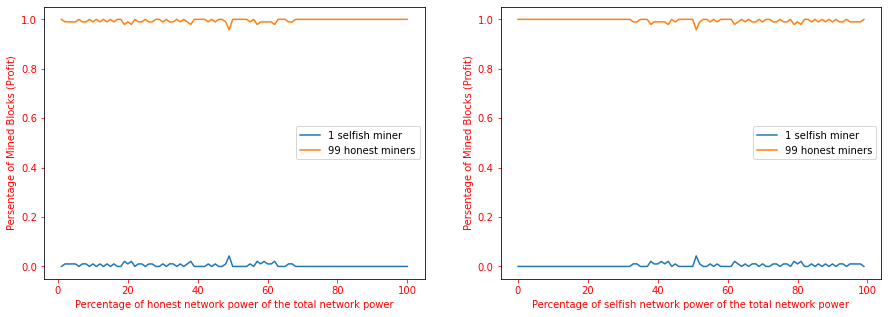

In [23]:
"""
Drawing the results of the previous simulation

--- Simulation Details ---
A) Total available mining power of 100
B) Total number of miners is 100
C) Mining power are equal for each miner, i.e. 1 for each miner
D) Having 99 honest miners, and 1 selfish miners at each step throughout the simulation

E) Total available network power of 100
F) Miners have different network powers, beacuse we are
1. Increasing the total selfish network power from 0 to 99 with selfish_network_power += 1, and
    this total amount of selfish network power is dedicated to the one selfish miner.
2. Decreasing the total honest network power from 100 to 1 with honest_network_power -= 1, and
    this total amount of honest network power is divided on the 99 honest miners.
"""
import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "1 selfish miner")
axs[0].plot(honest_power, honest_profits, label = "99 honest miners")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of honest network power of the total network power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "1 selfish miner")
axs[1].plot(selfish_power, honest_profits, label = "99 honest miners")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish network power of the total network power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[1].legend()

In [25]:
"""
--- Simulation Details ---
A) Total available network power of 100
B) starting the total selfish network power at 0, and
C) starting the total honest network power at 100

D) Total number of miners is 100

E) Each miner will have the same network power as other miners, beacuse we are
    1. Increasing the selfish network power from 0 to 99 with selfish_network_power += 1, and 
        at the same time increasing the number of selfish miners from 0 to 99 with 
        num_selfish_miners += 1
    2. decreasing the honest network power from 0 to 99 with honest_power += 1, and 
        at the same time decreasing the number of honest miners from 0 to 99 with 
        num_honest_miners += 1

F) Total available mining power of 100, with equal mining power between all miners
"""

output = True
selfish_profits = []
honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

print("Simulating varying network power between miners with")
print("-> equal mining power for each miner")
print("-> and varying the number of honest and selfish miners at each simulation")
print("")

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    
    total_mining_power = 100
    honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
    selfish_mining_power_share = round(num_of_selfish_miners/total_mining_power, 2)
    honest_mining_power = round(total_mining_power * honest_mining_power_share)
    selfish_mining_power = round(total_mining_power * selfish_mining_power_share)
    
    total_network_power = 100
    honest_network_power_share = round(num_of_honest_miners/total_network_power, 2)
    selfish_network_power_share = round(num_of_selfish_miners/total_network_power, 2)
    honest_network_power = round(total_network_power * honest_network_power_share)
    selfish_network_power = round(total_network_power * selfish_network_power_share)

    bc = Blockchain("0" , 11)
    
    honest_miners = make_miners("honest", honest_network_power, num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", selfish_network_power, num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation with:")
        print(f"-> {len(honest_miners)} honest minors having {honest_network_power}% of total networking power and {honest_mining_power}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {selfish_network_power}% of total networking power and {selfish_mining_power}% of total mining power")
        print("...")
        
    selfish_profit, honest_profit = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    selfish_profits.append(selfish_profit)
    honest_profits.append(honest_profit)
    
    if output:
        print(f"Honest profit: {honest_profit}")
        print(f"Selfish profit: {selfish_profit}")
        print(f"Total profit: {round(selfish_profit+honest_profit)}")
        print()
    

Simulating varying network power between miners with
-> equal mining power for each miner
-> and varying the number of honest and selfish miners at each simulation

Running simulation with:
-> 100 honest minors having 100% of total networking power and 100% of total mining power
-> 0 selfish minors having 0% of total networking power and 0% of total mining power
...
Honest profit: 1.0000000000000007
Selfish profit: 0
Total profit: 1

Running simulation with:
-> 99 honest minors having 99% of total networking power and 99% of total mining power
-> 1 selfish minors having 1% of total networking power and 1% of total mining power
...
Honest profit: 0.9999999999999993
Selfish profit: 0.0
Total profit: 1

Running simulation with:
-> 98 honest minors having 98% of total networking power and 98% of total mining power
-> 2 selfish minors having 2% of total networking power and 2% of total mining power
...
Honest profit: 1.0
Selfish profit: 0.0
Total profit: 1

Running simulation with:
-> 97 ho

Honest profit: 0.9999999999999996
Selfish profit: 0.0
Total profit: 1

Running simulation with:
-> 70 honest minors having 70% of total networking power and 70% of total mining power
-> 30 selfish minors having 30% of total networking power and 30% of total mining power
...
Honest profit: 0.9729729729729728
Selfish profit: 0.02702702702702703
Total profit: 1

Running simulation with:
-> 69 honest minors having 69% of total networking power and 69% of total mining power
-> 31 selfish minors having 31% of total networking power and 31% of total mining power
...
Honest profit: 0.9705882352941171
Selfish profit: 0.029411764705882353
Total profit: 1

Running simulation with:
-> 68 honest minors having 68% of total networking power and 68% of total mining power
-> 32 selfish minors having 32% of total networking power and 32% of total mining power
...
Honest profit: 0.96875
Selfish profit: 0.03125
Total profit: 1

Running simulation with:
-> 67 honest minors having 67% of total networking po

Honest profit: 0.8600000000000002
Selfish profit: 0.14
Total profit: 1

Running simulation with:
-> 41 honest minors having 41% of total networking power and 41% of total mining power
-> 59 selfish minors having 59% of total networking power and 59% of total mining power
...
Honest profit: 0.8749999999999998
Selfish profit: 0.125
Total profit: 1

Running simulation with:
-> 40 honest minors having 40% of total networking power and 40% of total mining power
-> 60 selfish minors having 60% of total networking power and 60% of total mining power
...
Honest profit: 0.9215686274509806
Selfish profit: 0.0784313725490196
Total profit: 1

Running simulation with:
-> 39 honest minors having 39% of total networking power and 39% of total mining power
-> 61 selfish minors having 61% of total networking power and 61% of total mining power
...
Honest profit: 0.813953488372093
Selfish profit: 0.18604651162790697
Total profit: 1

Running simulation with:
-> 38 honest minors having 38% of total networ

Honest profit: 0.2857142857142857
Selfish profit: 0.7142857142857142
Total profit: 1

Running simulation with:
-> 12 honest minors having 12% of total networking power and 12% of total mining power
-> 88 selfish minors having 88% of total networking power and 88% of total mining power
...
Honest profit: 0.6086956521739131
Selfish profit: 0.3913043478260869
Total profit: 1

Running simulation with:
-> 11 honest minors having 11% of total networking power and 11% of total mining power
-> 89 selfish minors having 89% of total networking power and 89% of total mining power
...
Honest profit: 0.4375
Selfish profit: 0.5625
Total profit: 1

Running simulation with:
-> 10 honest minors having 10% of total networking power and 10% of total mining power
-> 90 selfish minors having 90% of total networking power and 90% of total mining power
...
Honest profit: 0.3461538461538462
Selfish profit: 0.653846153846154
Total profit: 1

Running simulation with:
-> 9 honest minors having 9% of total networ

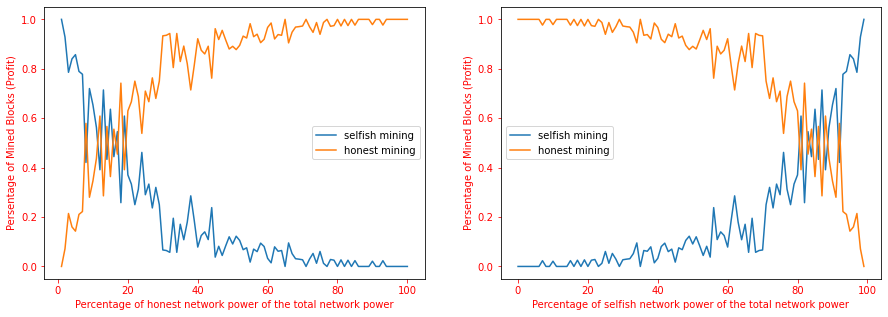

In [28]:
"""
Drawing the results of the previous simulation

--- Simulation Details ---
A) Total available network power of 100
B) starting the total selfish network power at 0, and
C) starting the total honest network power at 100

D) Total number of miners is 100

E) Each miner will have the same network power as other miners, beacuse we are
    1. Increasing the selfish network power from 0 to 99 with selfish_network_power += 1, and 
        at the same time increasing the number of selfish miners from 0 to 99 with 
        num_selfish_miners += 1
    2. decreasing the honest network power from 0 to 99 with honest_power += 1, and 
        at the same time decreasing the number of honest miners from 0 to 99 with 
        num_honest_miners += 1

F) Total available mining power of 100, with equal mining power between all miners
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(honest_power, selfish_profits, label = "selfish mining")
axs[0].plot(honest_power, honest_profits, label = "honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of honest network power of the total network power').set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[0].legend()

axs[1].plot(selfish_power, selfish_profits, label = "selfish mining")
axs[1].plot(selfish_power, honest_profits, label = "honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish network power of the total network power').set_color('red')
axs[1].set_ylabel('Persentage of Mined Blocks (Profit)').set_color('red')
axs[1].legend()